
<div style="text-align: center;">
  <img width="420" height="420" src="https://www.naterscreations.com/imputegap/logo_imputegab.png" />
</div>

<h1>ImputeGAP: Advanced Analysis Notebook</h1>

ImputeGAP is a complete end-to-end imputation library that supports the entire workflow —from data collection to interpreting imputation results and assessing their impact. It features two interconnected components: the imputation pipeline and the advanced analysis module. These can be used together via a standardized configuration-driven pipeline or independently through manual instantiation.

This notebook demonstrates components of the explore unit, including benchmarking, downstream evaluation, and the explainer.
Before proceeding, please ensure the library and required Jupyter dependencies are installed:

In [ ]:
%pip install imputegap==1.0.9

In [ ]:
%pip install -U ipywidgets

<h1>Benchmark</h1>

ImputeGAP can serve as a common test-bed for comparing the effectiveness and efficiency of time series imputation algorithms. Users have full control over the benchmark by customizing various parameters, including the list of the algorithms to compare, the optimizer, the datasets to evaluate, the missingness patterns, the range of missing values, and the performance metrics.

The benchmarking module can be utilized as follows:

In [10]:
%matplotlib inline
from imputegap.recovery.benchmark import Benchmark

my_algorithms = ["SoftImpute", "KNNImpute"]

my_opt = ["default_params"]

my_datasets = ["eeg-alcohol"]

my_patterns = ["mcar"]

range = [0.05, 0.1, 0.2, 0.4, 0.6, 0.8]

my_metrics = ["*"]

# launch the evaluation
bench = Benchmark()
bench.eval(algorithms=my_algorithms, datasets=my_datasets, patterns=my_patterns, x_axis=range, metrics=my_metrics, optimizers=my_opt)


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/eeg-alcohol.txt

SoftImpute using mcar, started at 2025-04-10 15:28:10.
done!


KNNImpute using mcar, started at 2025-04-10 15:28:12.
done!



> logs: benchmark - Execution Time: 5.4656 seconds


eegalcohol: {mcar, RMSE, default_params}

 Rate       KNNImpute           SoftImpute     

 0.05      0.2410259540        0.4359915238    
  0.1      0.2889085181        0.3665001858    
  0.2      0.3252384253        0.3983300622    
  0.4      0.3382458476        0.4355910162    
  0.6      0.3656435952        0.4500113662    
  0.8      0.4985193265        0.4655442240    



eegalcohol: {mcar, runtime, default_params}

 Rate       KNNImpute           SoftImpute     

 0.05      0.0676102638        0.3653552532    
  0.1      0.0483939648        0.3321225643    
  0.2      0.0560669899        0.2812151909    
  0.4      0.0920848846        0.2621650696    
  0.6      0.27

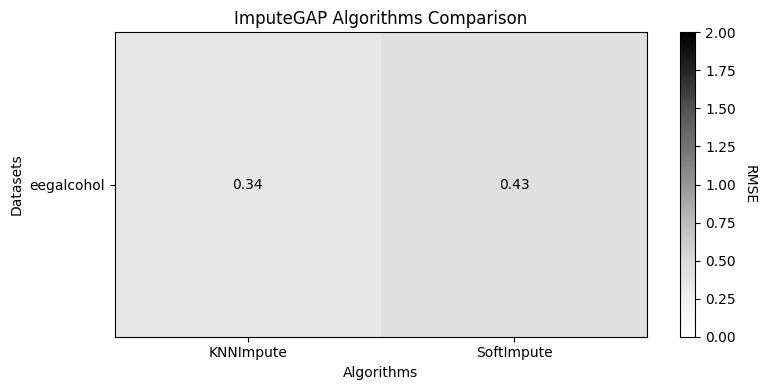

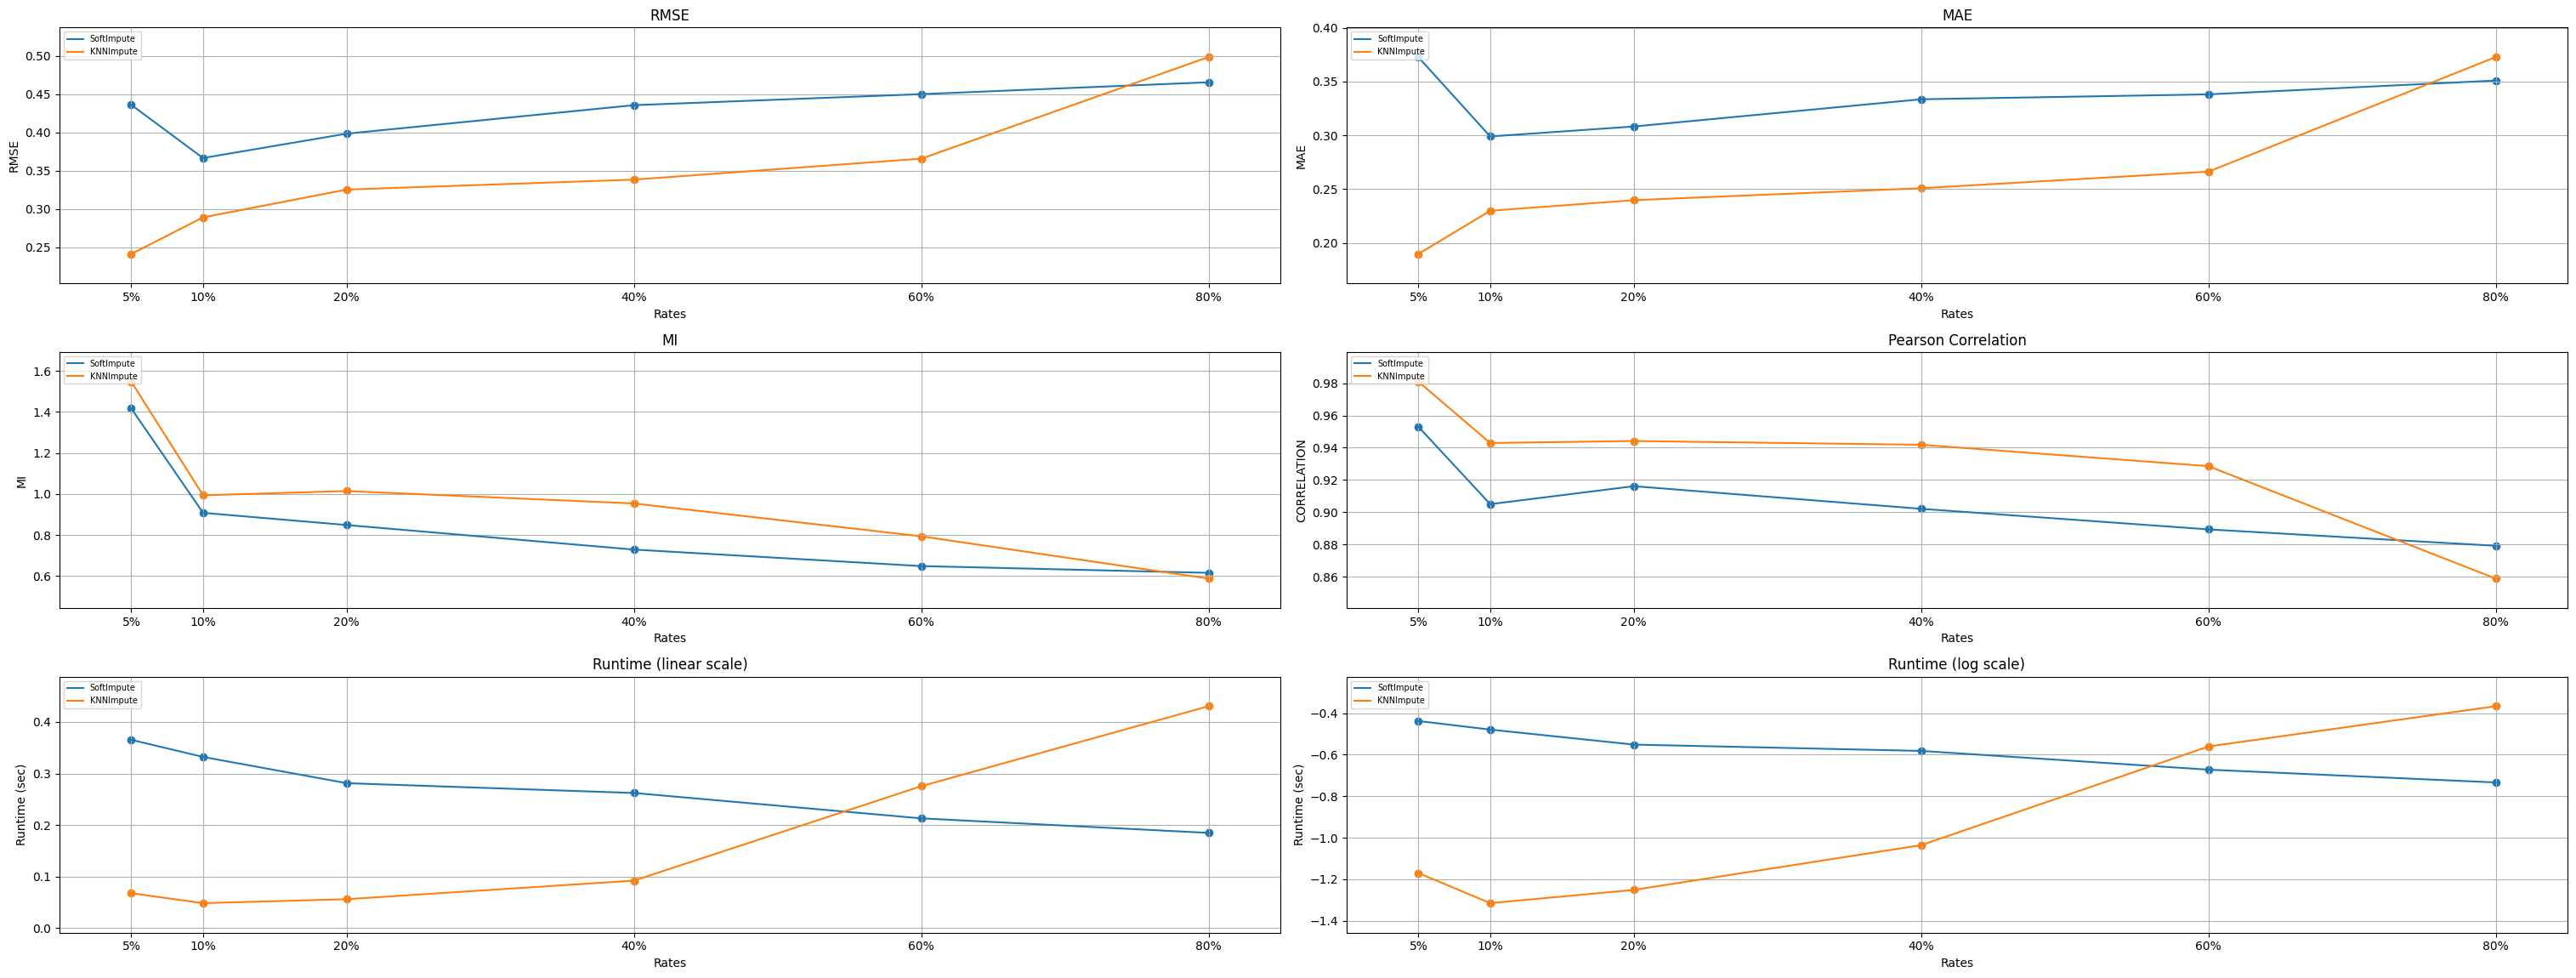

In [11]:
%matplotlib inline
bench.plots.show()

You can enable the optimizer using the following command:

In [12]:
opt = {"optimizer": "ray_tune", "options": {"n_calls": 1, "max_concurrent_trials": 1}}
my_opt = [opt]

<br>

<h1>Downstream</h1>

ImputeGAP includes a dedicated module for systematically evaluating the impact of data imputation on downstream tasks. Currently, forecasting is the primary supported task, with plans to expand to additional tasks in the future.

In [13]:
from imputegap.recovery.imputation import Imputation
from imputegap.recovery.manager import TimeSeries
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()

# load and normalize the timeseries
ts.load_series(utils.search_path("forecast-economy"))
ts.normalize()

# contaminate the time series
ts_m = ts.Contamination.aligned(ts.data, rate_series=0.8)

# define and impute the contaminated series
imputer = Imputation.MatrixCompletion.CDRec(ts_m)
imputer.impute()

# compute and print the downstream results
downstream_config = {"task": "forecast", "model": "hw-add", "comparator": "ZeroImpute"}
imputer.score(ts.data, imputer.recov_data, downstream=downstream_config)
ts.print_results(imputer.downstream_metrics, algorithm=imputer.algorithm)


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/forecast-economy.txt

> logs: normalization (z_score) of the data - runtime: 0.0008 seconds

(CONT) missigness pattern: ALIGNED
	percentage of contaminated series: 20.0%
	rate of missing data per series: 80.0%
	security offset: [0-93]
	index impacted : 93 -> 837

(IMPUTATION) CDRec: (16,931) with rank 3, epsilon 1e-06, and iterations 100.
> logs: imputation cdrec - Execution Time: 8.8226 seconds.

(DOWNSTREAM) Default parameters of the downstream model loaded.

(DOWNSTREAM) Analysis launched !
task: forecast
model: hw-add
params: {'sp': 7, 'trend': 'add', 'seasonal': 'additive'}
base algorithm: cdrec
reference algorithm: ZeroImpute

plots saved in:  ./imputegap_assets/downstream

Results (cdrec) :
MSE_original         = 0.5664449450187778
MSE_CDREC            = 0.5849456079752088
MSE_ZEROIMPUTE       = 0.6242535371188614
sMAPE_original       = 89.44732801706094
sMAPE

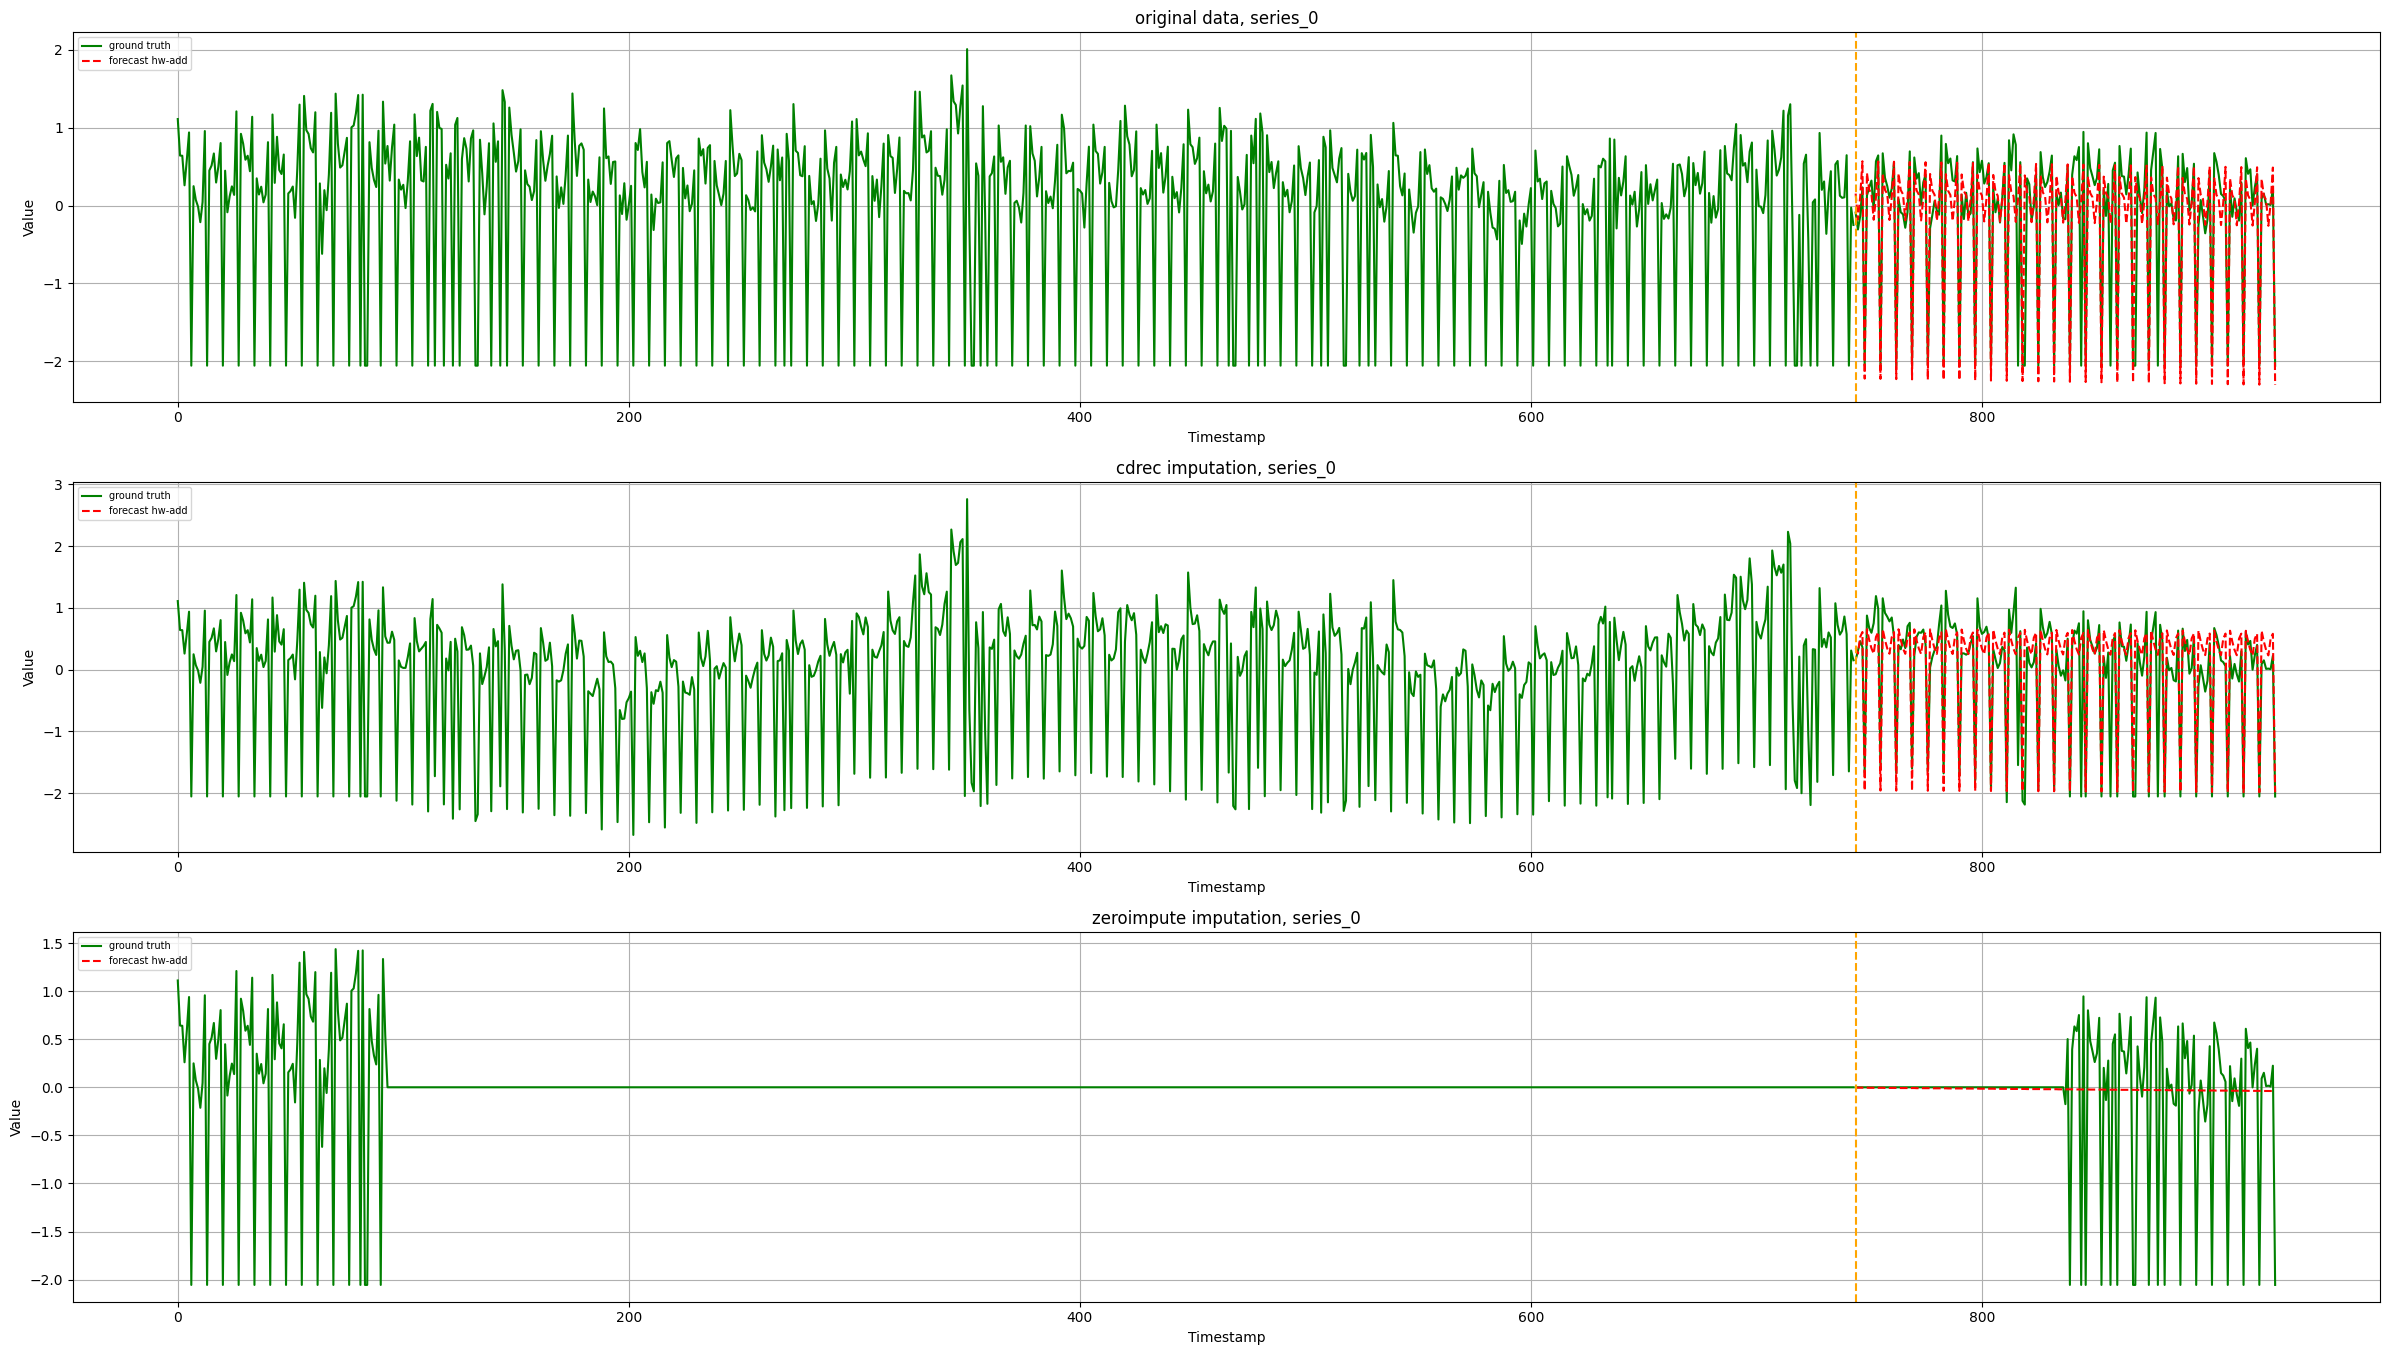

In [14]:
%matplotlib inline
imputer.downstream_plot.show()

<br>

All downstream models develboped in ImputeGAP are available in the ``ts.forecasting_models`` module, which can be listed as follows:

In [15]:
ts.forecasting_models

['arima',
 'bats',
 'croston',
 'deepar',
 'ets',
 'exp-smoothing',
 'hw-add',
 'lightgbm',
 'lstm',
 'naive',
 'nbeats',
 'prophet',
 'sf-arima',
 'theta',
 'transformer',
 'unobs',
 'xgboost']

<br>

<h1>Explainer</h1>

The library provides insights into the algorithm’s behavior by identifying the features that impact the imputation results. It trains a regression model to predict imputation results across various methods and uses SHapley Additive exPlanations (SHAP) to reveal how different time series features influence the model’s predictions.

Let’s illustrate the explainer using the CDRec algorithm and MCAR missingness pattern:

In [16]:
from imputegap.recovery.manager import TimeSeries
from imputegap.recovery.explainer import Explainer
from imputegap.tools import utils

# initialize the time series object
ts = TimeSeries()
exp = Explainer()

# load and normalize the timeseries
ts.load_series(utils.search_path("eeg-alcohol"))
ts.normalize(normalizer="z_score")

# configure the explanation
exp.shap_explainer(input_data=ts.data, extractor="pycatch", pattern="mcar", file_name=ts.name, algorithm="CDRec", display=True)

# print the impact of each feature
exp.print(exp.shap_values, exp.shap_details)


(SYS) The time series have been loaded from /mnt/c/Users/nquen/switchdrive/MST_MasterThesis/imputegap/imputegap/dataset/eeg-alcohol.txt

> logs: normalization (z_score) of the data - runtime: 0.0010 seconds

explainer launched
	extractor: pycatch 
	imputation algorithm: CDRec 
	params: None 
	missigness pattern: mcar
	missing rate: 40.0%
	nbr of series training set: 38
	nbr of series testing set: 26


Generation  0 / 64 ( 0 %)________________________________________________________
	Contamination  0 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  0 ...


Generation  1 / 64 ( 1 %)________________________________________________________
	Contamination  1 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  1 ...


Generation  2 / 64 ( 3 %)________________________________________________________
	Contamination  2 ...
	pycatch22 : features extracted successfully___22 features
	Imputation  2 ...


Generation  3 / 64 ( 4 %)_________________

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]



	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_all.png


	plot has been saved :  ./imputegap_assets/shap/eeg-alcohol_CDRec_pycatch_shap_cat.png

> logs: shap explainer - Execution Time: 62.7146 seconds


SHAP results saved in: ./imputegap_assets/shap/*


Top-5 features:
	Feature : eeg-alcohol CDRec      with a score of 29.63      Geometry           Goodness of exponential fit to embedding distance distribution              CO_Embed2_Dist_tau_d_expfit_meandiff

	Feature : eeg-alcohol CDRec      with a score of 16.55      Transformation     Power in the lowest 20% of frequencies                                      SP_Summaries_welch_rect_area_5_1

	Feature : eeg-alcohol CDRec      with a score of 9.7        Geometry           10-bin histogram mode                                                       DN_HistogramMode_10

	Feature : eeg-alcohol CDRec      with a score of 7.67       Correlation        Histogram-based automutual information (lag 2, 5 bins)

<br>

All feature extractors developed in ImputeGAP are available in the ``ts.extractors`` module. They can be listed as follows:

In [17]:
ts.extractors

['pycatch', 'tsfel', 'tsfresh']